In [217]:
from scipy.io import wavfile as WF

from IPython.display import Audio
import pandas as pd
import numpy as np
from numpy.fft import fft
from scipy.signal import * 
import matplotlib.pyplot as plt

from tqdm import tqdm

ImportError: No module named tqdm

In [ ]:
def thirdoct(rate, k, n_bands, mn):
    freqs = np.linspace(0, rate, k + 1)
    freqs = freqs[0:int(k/2 + 1)]
    q = np.arange(n_bands)
    cf = np.power(2, q/3.) * mn
    fl = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q - 1.)/3.) * mn))
    fr = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q + 1.)/3.) * mn))
    A = np.zeros((n_bands, freqs.shape[0]))
    for i in range(cf.shape[0]):
        tmp = np.square(freqs-fl[i])
        a, b = np.min(tmp), np.argmin(tmp)
        fl[i] = freqs[b]
        flii = b
        
        tmp = np.square(freqs-fr[i])
        a, b = np.min(tmp), np.argmin(tmp)
        fr[i] = freqs[b]
        frii = b
        A[i, flii:(frii)] = 1
    rnk = np.sum(A, axis=1)
    nb_ = np.where(np.logical_and(rnk[1:] >= rnk[:-1], rnk[1:] != 0))[0]
    nb = nb_[-1] + 2 #because matlab
    A = A[:nb, :]
    cf = cf[:nb]
    return A, cf

def stdft(x, N, K, N_fft): 
    frames = np.arange(0, x.shape[0]-N, K)
    x_stdft = np.zeros((frames.shape[0], N_fft), dtype=np.complex)
    w = hanning(N)
    x = x.T
    for i in range(frames.shape[0]):
        if (x[frames[i: i + N]].shape != w.shape):
            tmp = np.zeros_like(w)
            q = x[frames[i: i + N]]
            tmp[:q.shape[0]] = q
            x_stdft[i, :] = fft(tmp * w, n=N_fft)
        else:
            x_stdft[i, :] = fft(x[frames[i: i + N]] * w, n=N_fft)
    return x_stdft

def taa_corr(x, y):
    def normalize(x):
        xn = x - np.mean(x)
        return xn / np.sqrt(np.square(xn).sum())
    
    return np.dot(normalize(x), normalize(y)).sum()

def intermediate_metric(x, y, n_frame=256, k=512, J=15, N=30, n_bands=15, cf=150, rate=16000):
    H,_ = thirdoct(rate, k, n_bands, cf) #1/3 octave band matrix
    
    x_hat = stdft(x, n_frame, int(n_frame / 2), k)
    y_hat = stdft(y, n_frame, int(n_frame / 2), k)

    x_hat = x_hat[:, :int(k/2) + 1].T
    y_hat = y_hat[:, :int(k/2) + 1].T

    X = np.zeros((J, x_hat.shape[1]))
    Y = np.zeros((J, y_hat.shape[1]))
    for i in range(x_hat.shape[1]):
        X[:, i] = np.sqrt(np.dot(H, np.square(np.abs(x_hat[:, i]))))
        Y[:, i] = np.sqrt(np.dot(H, np.square(np.abs(y_hat[:, i]))))

    # allocating memory for intermediate measures
    d_interm = np.zeros((J, X.shape[1] - N))
    c=np.power(10., 0.75) #clipping constant

    for m in range(N, X.shape[1]):
        X_seg = X[:, (m - N):m]
        Y_seg = Y[:, (m - N):m] 
        alpha = np.sqrt(np.sum(np.square(X_seg), axis=1) / np.sum(np.square(Y_seg), axis=1))
        aY_seg = Y_seg * np.matlib.repmat(alpha, 1, N).reshape(Y_seg.shape)
        for j in range(J):
            Y_prime = np.minimum(aY_seg[j, :], X_seg[j, :] + X_seg[j, :] * c)
            d_interm[j, m-N] = taa_corr(X_seg[j, :].T, Y_prime)

    return d_interm

def stoi(x, y):
    return np.mean(intermediate_metric(x, y))

In [ ]:
rate, data = WF.read('sound.wav')
plt.plot(data)
plt.title('rate = {}'.format(rate))
plt.show()

In [ ]:
def gen_noise(magn=10, size=80000):
    return np.random.normal(scale=magn, size=size).astype(np.int16)

In [218]:
n_frame = 256 # window
k = 512 # fft size
J = 15
N = 30
n_bands = 15
cf = 150 # center frequency of first 1/3 octave band in Hz
x = data
noise = gen_noise(200)
y = data + noise

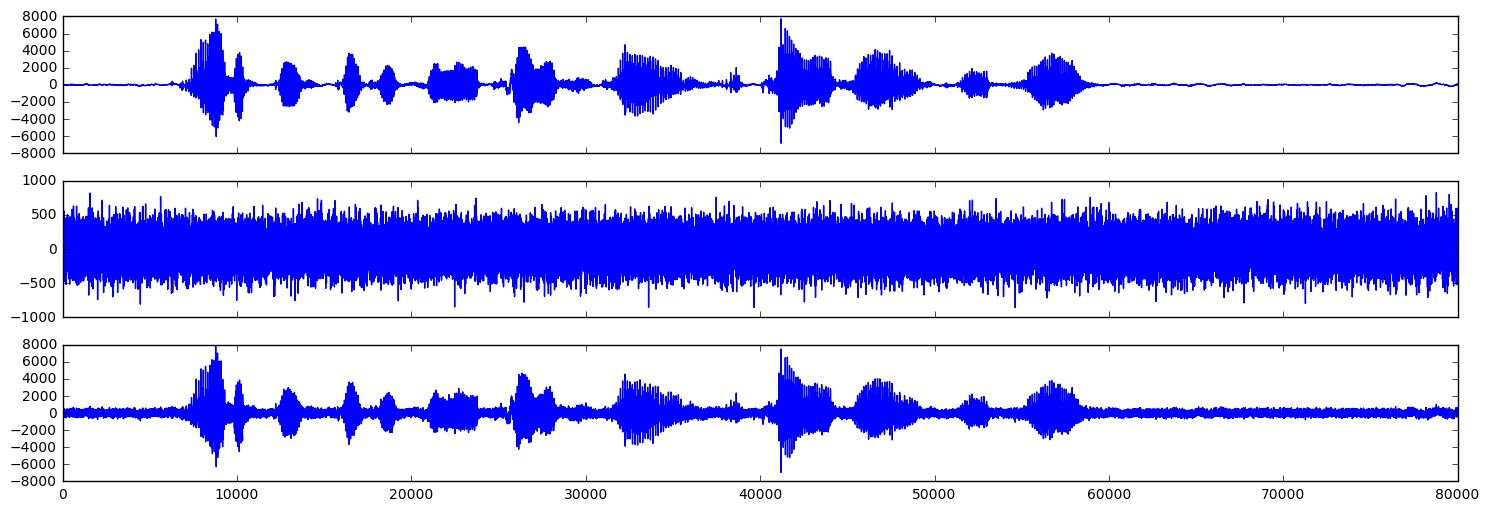

In [219]:
fig, ax = plt.subplots(3, 1, figsize=(18, 6), sharex=True)
ax[0].plot(x)
ax[1].plot(noise)
ax[2].plot(y)
plt.show()

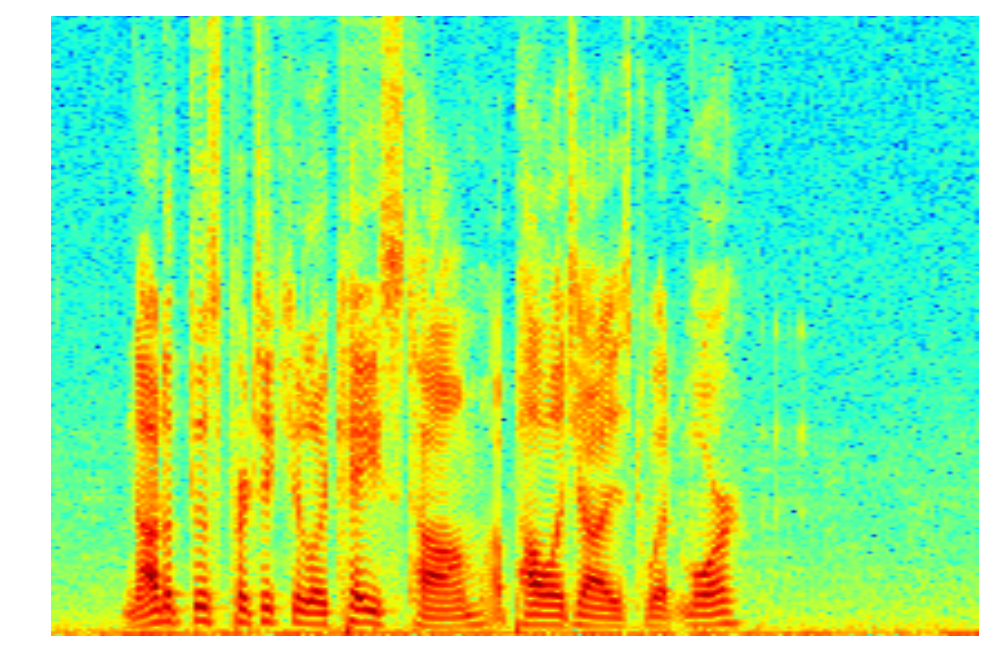

In [220]:
plt.figure(figsize=(12, 8))
_, _, _, im = plt.specgram(data, Fs=1e4, NFFT=512)
plt.axis('off')
plt.show()

In [221]:
d_interm = intermediate_metric(x, y)
d = stoi(x, y)

In [222]:
noise_magn = np.array([0, 1, 2, 5, 10, 20, 30, 40, 50, 80, 100, 120, 150, 180, 200, 250, 300, 350, 400])
d = np.array([stoi(x, x + gen_noise(m)) for m in noise_magn])

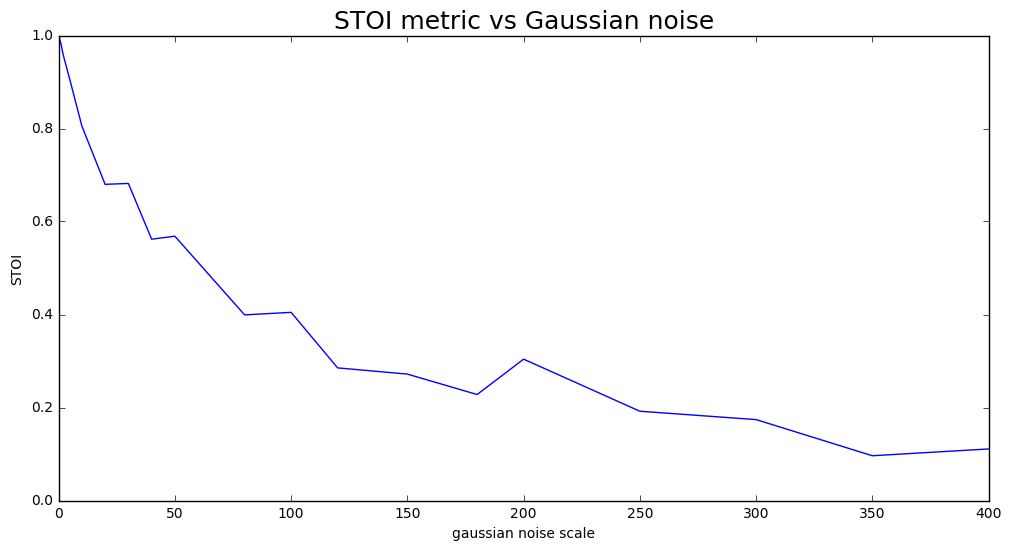

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(noise_magn, d)
plt.xlabel('gaussian noise scale')
plt.ylabel('STOI')
plt.title('STOI metric vs Gaussian noise', fontsize=18)
plt.show()

In [224]:
frames = np.arange(0, data.shape[0]-256, 128)
windows = np.array([data[frames[i]: frames[i+2]] for i in range(frames.shape[0] - 2)])
windows.shape

(621, 256)

In [225]:
x = data
noise = gen_noise(20)
y = data + noise
d_interm = intermediate_metric(y, x)

In [226]:
d_ = d_interm.mean(axis=0)

In [227]:
print(d_.shape)
t=580
plt.figure(figsize=(12, 6))
plt.plot(y / np.max(y))
plt.plot(np.linspace(0, x.shape[0], d_.shape[0])[:t], norm(d_ + np.min(d_))[:t])
plt.title('Intermediate intelligibility over time', fontsize=18)
plt.show()

(593,)


NameError: name 'norm' is not defined

## Denoising stuff

In [ ]:
import numpy

# from https://www.cis.rit.edu/~cnspci/media/software/psnr.py

def psnr(dataset1, dataset2, maximumDataValue, ignore=None):
   """
   title::
      psnr

   description::
      This method will compute the peak-signal-to-noise ratio (PSNR) between
      two provided data sets.  The PSNR will be computed for the ensemble
      data.  If the PSNR is desired for a particular slice of the provided
      data, then the data sets provided should represent those slices.

   attributes::
      dataset1
         An array-like object containing the first data set.
      dataset2
         An array-like object containing the second data set.
      maximumDataValue
         The maximum value that might be contained in the data set (this
         is not necessarily the maximum value in the data set, but 
         rather it is the largest value that any member of the data set 
         might take on).
      ignore
         A scalar value that will be ignored in the data sets.  This can
         be used to mask data in the provided data set from being
         included in the analysis. This value will be looked for in both
         of the provided data sets, and only an intersection of positions
         in the two data sets will be included in the computation. [default 
         is None]

   author::
      Carl Salvaggio

   copyright::
      Copyright (C) 2015, Rochester Institute of Technology

   license::
      GPL

   version::
      1.0.0

   disclaimer::
      This source code is provided "as is" and without warranties as to 
      performance or merchantability. The author and/or distributors of 
      this source code may have made statements about this source code. 
      Any such statements do not constitute warranties and shall not be 
      relied on by the user in deciding whether to use this source code.
      
      This source code is provided without any express or implied warranties 
      whatsoever. Because of the diversity of conditions and hardware under 
      which this source code may be used, no warranty of fitness for a 
      particular purpose is offered. The user is advised to test the source 
      code thoroughly before relying on it. The user must assume the entire 
      risk of using the source code.
   """

   # Make sure that the provided data sets are numpy ndarrays, if not
   # convert them and flatten te data sets for analysis
   if type(dataset1).__module__ != numpy.__name__:
      d1 = numpy.asarray(dataset1).flatten()
   else:
      d1 = dataset1.flatten()

   if type(dataset2).__module__ != numpy.__name__:
      d2 = numpy.asarray(dataset2).flatten()
   else:
      d2 = dataset2.flatten()

   # Make sure that the provided data sets are the same size
   if d1.size != d2.size:
      raise ValueError('Provided datasets must have the same size/shape')

   # Check if the provided data sets are identical, and if so, return an
   # infinite peak-signal-to-noise ratio
   if numpy.array_equal(d1, d2):
      return float('inf')

   # If specified, remove the values to ignore from the analysis and compute
   # the element-wise difference between the data sets
   if ignore is not None:
      index = numpy.intersect1d(numpy.where(d1 != ignore)[0], 
                                numpy.where(d2 != ignore)[0])
      error = d1[index].astype(numpy.float64) - d2[index].astype(numpy.float64)
   else:
      error = d1.astype(numpy.float64)-d2.astype(numpy.float64)

   # Compute the mean-squared error
   meanSquaredError = numpy.sum(error**2) / error.size

   # Return the peak-signal-to-noise ratio
   return 10.0 * numpy.log10(maximumDataValue**2 / meanSquaredError)

In [230]:
from numpy.fft import fftfreq, fft, ifft

def fft_denoise(y, lmbd):
    # take the fourier transform of the data
    F = fft(y)

    mean_val = np.mean(np.abs(F))
    thr = (1 + lmbd) * mean_val

    F[abs(F) < thr] = 0
    S = ifft(F)
    
    return S

In [ ]:
def gen_noise_float(magn=10, size=80000):
    return np.random.normal(scale=magn, size=size)

x_norm = x / float(np.abs(x).max())
noise2 = gen_noise2(0.02)
y_norm = x_norm + noise2

In [228]:
print 'psnr', psnr(x_norm, y_norm, 1.)

psnr 34.0067117168


In [234]:
lambdas = np.logspace(-2, 0, 20)
errors = np.zeros_like(lambdas)
psnrs = np.zeros_like(lambdas)

sound_gaussian = x_norm
sound_original = y_norm

stois = np.zeros_like(lambdas)

for i in range(len(lambdas)):
    restored_img_1 = fft_denoise(sound_gaussian, lambdas[i])
    
    errors[i] = np.linalg.norm(restored_img_1 - sound_original)
    
    psnrs[i] = psnr(restored_img_1, sound_original, 1.)

    stois[i] = stoi(sound_original, np.array(restored_img_1).flatten())

/Users/rayman/Downloads/skoltech/optmet/env/lib/python2.7/site-packages/ipykernel/__main__.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/rayman/Downloads/skoltech/optmet/env/lib/python2.7/site-packages/ipykernel/__main__.py:36: ComplexWarning: Casting complex values to real discards the imaginary part


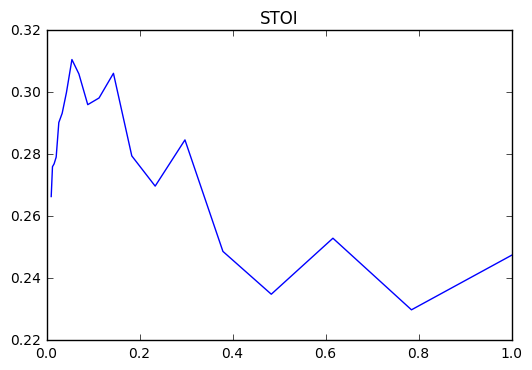

In [237]:
plt.plot(lambdas, stois, label = 'errors')
plt.title('STOI')
plt.show()

In [239]:
import cvxpy

def tikhonov_solve(img, m_lambda):    
    x = cvxpy.Variable(80000, 1)
    
    constraints = [x >= -1., x <= 1.]
    objective = cvxpy.norm2(x - img) / 2. + \
                m_lambda * (cvxpy.norm2(x[:-1, :] - x[1:, :]))
        
    problem = cvxpy.Problem(cvxpy.Minimize(objective), constraints)
    problem.solve(solver = 'SCS', max_iters = 1000)
    
    return problem.variables()[0].value

In [247]:
lambdas = np.logspace(-2, 0, 20)
errors = np.zeros_like(lambdas)
psnrs = np.zeros_like(lambdas)

sound_gaussian = np.abs(y_norm.reshape((80000, 1)))
sound_original = np.abs(x_norm.reshape((80000, 1)))

stois = np.zeros_like(lambdas)

for i in range(len(lambdas)):
    print i
    
    restored_img_1 = tikhonov_solve(sound_gaussian, lambdas[i])
    
    errors[i] = np.linalg.norm(restored_img_1 - sound_original)
    
    psnrs[i] = psnr(restored_img_1, sound_original, 1.)

    stois[i] = stoi(sound_original.flatten(), np.array(restored_img_1).flatten())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


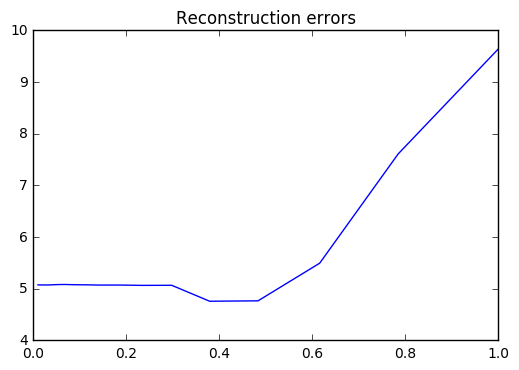

In [244]:
plt.plot(lambdas, errors, label = 'errors')
plt.title('Reconstruction errors')
plt.show()

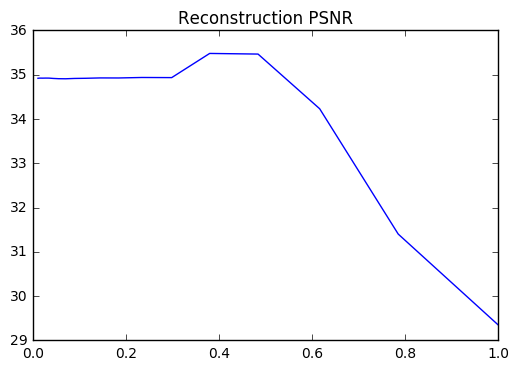

In [245]:
plt.plot(lambdas, psnrs)
plt.title('Reconstruction PSNR')
plt.show()

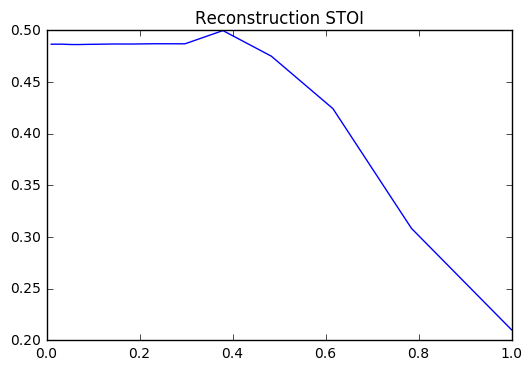

In [248]:
plt.plot(lambdas, stois)
plt.title('Reconstruction STOI')
plt.show()